In [1]:
%env THEANO_FLAGS='device=cuda','floatX=float32','gpuarray.preallocate=0.25','linker=c|py', 'optimizer=fast_run'

env: THEANO_FLAGS='device=cuda','floatX=float32','gpuarray.preallocate=0.25','linker=c|py', 'optimizer=fast_run'


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np

import theano
import theano.tensor as T

import craynn

from craynn.layers import *
from craynn.subnetworks import *
from craynn.networks import *
from craynn.updates import *

from craynn.viz import draw_to_notebook, SNNWatcher

from theano.sandbox.rng_mrg import MRG_RandomStreams
srng = MRG_RandomStreams(seed=12345)

Using cuDNN version 7005 on context None
Preallocating 2027/8110 Mb (0.250000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [4]:
n = 16
code_size = 64

f = T.nnet.softplus

encoder = net((None, 1, 28, 28))(
    conv(n, f=f), conv(n, f=f), max_pool(),
    conv(int(1.5 * n), f=f), conv(int(1.5 * n), f=f), max_pool(),
    conv(2 * n, f=f),
    [dense(code_size, f = lambda x: x), dense(code_size, f = lambda x: x)]
)

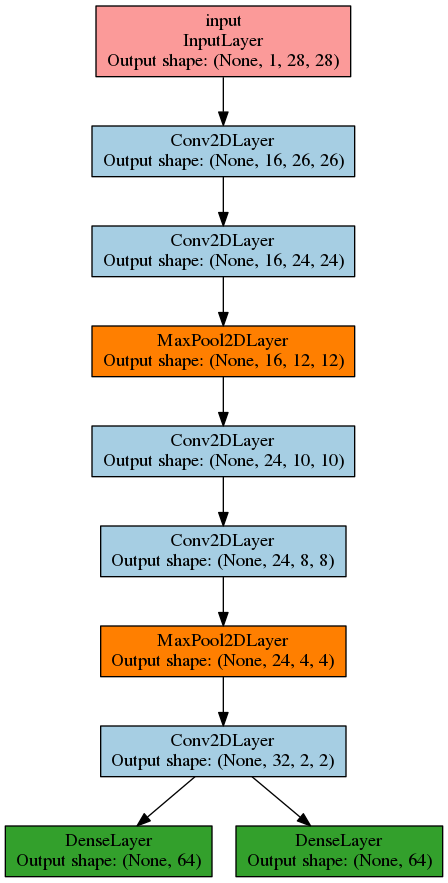

In [5]:
draw_to_notebook(encoder)

In [6]:
decoder = net((None, code_size))(
    reshape(-1, code_size, 1, 1),
    
    upscale(), deconv(2 * n, f=f),
    upscale(), deconv(int(1.5 * n), f=f), deconv(int(1.5 * n), f=f),
    upscale(), deconv(n, f=f), deconv(1, f=lambda x: x),
)

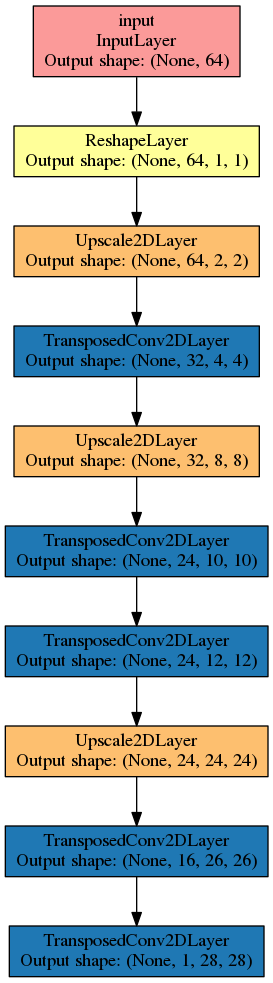

In [7]:
draw_to_notebook(decoder)

In [8]:
X = T.ftensor4()

In [9]:
code_mean, code_variance = encoder(X)

In [10]:
r_n = srng.normal(size=(X.shape[0], code_size), ndim=2, dtype='float32')

In [11]:
code = code_mean + r_n * code_variance

In [12]:
X_reconstructed, = decoder(code)

In [13]:
custom_code = T.fmatrix()
X_generated, = decoder(custom_code)

In [14]:
sigma = T.constant(1.0, dtype='float32')
normalization = T.constant(np.sqrt(2 * np.pi), dtype='float32') * sigma

### -log P(X | z)
reconstruction_errors = normalization + T.sum((X_reconstructed - X) ** 2, axis=(1, 2, 3)) / 2 / sigma ** 2
reconstruction_error = T.mean(reconstruction_errors)

In [15]:
### KL(Q(z | X) || P(z)) + ndim / 2
code_errors = 0.5 * (
    T.sum(code_variance ** 2, axis=1) + \
    T.sum(code_mean ** 2, axis=1) - \
    T.sum(T.log(code_variance ** 2), axis=1)
)

code_error = T.mean(code_errors)

In [16]:
loss = reconstruction_error + code_error

In [17]:
upd = adamax(loss, encoder.params() + decoder.params(), learning_rate=1.0e-3)

In [18]:
train = theano.function(
    [X],
    [reconstruction_error, code_error],
    updates=upd
)

In [19]:
generate = theano.function([custom_code], X_generated)

### Data

In [20]:
X_train, _, X_test, _ = craynn.utils.mnist(cast='float32')

In [21]:
X_train /= 255.0
X_test /= 255.0

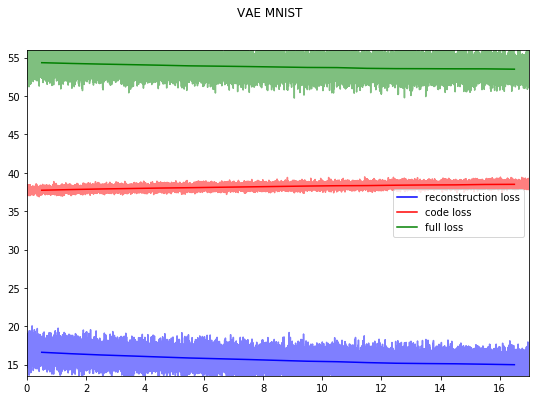

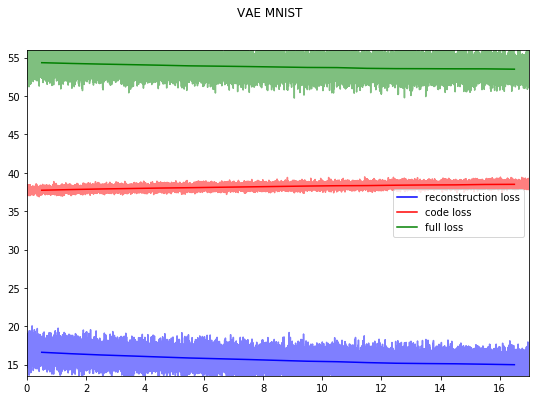

In [22]:
watcher = SNNWatcher(
    'VAE MNIST',
    labels=('reconstruction loss', 'code loss', 'full loss'),
    colors=('blue', 'red', 'green')
)

n_epoches = 32
batch_size = 32

n_batches = X_train.shape[0] // batch_size

stream = streams.inf_random(X_train.shape[0], batch_size=batch_size)

reco_losses = np.ndarray(shape=(n_epoches, n_batches), dtype='float32')
code_losses = np.ndarray(shape=(n_epoches, n_batches), dtype='float32')

for i in range(n_epoches):
    for j in range(n_batches):
        indx = next(stream)
        reco_losses[i, j], code_losses[i, j] = train(X_train[indx])
    
    watcher.draw(
        reco_losses[:(i + 1), :],
        code_losses[:(i + 1), :],
        code_losses[:(i + 1), :] + reco_losses[:(i + 1), :]
    )

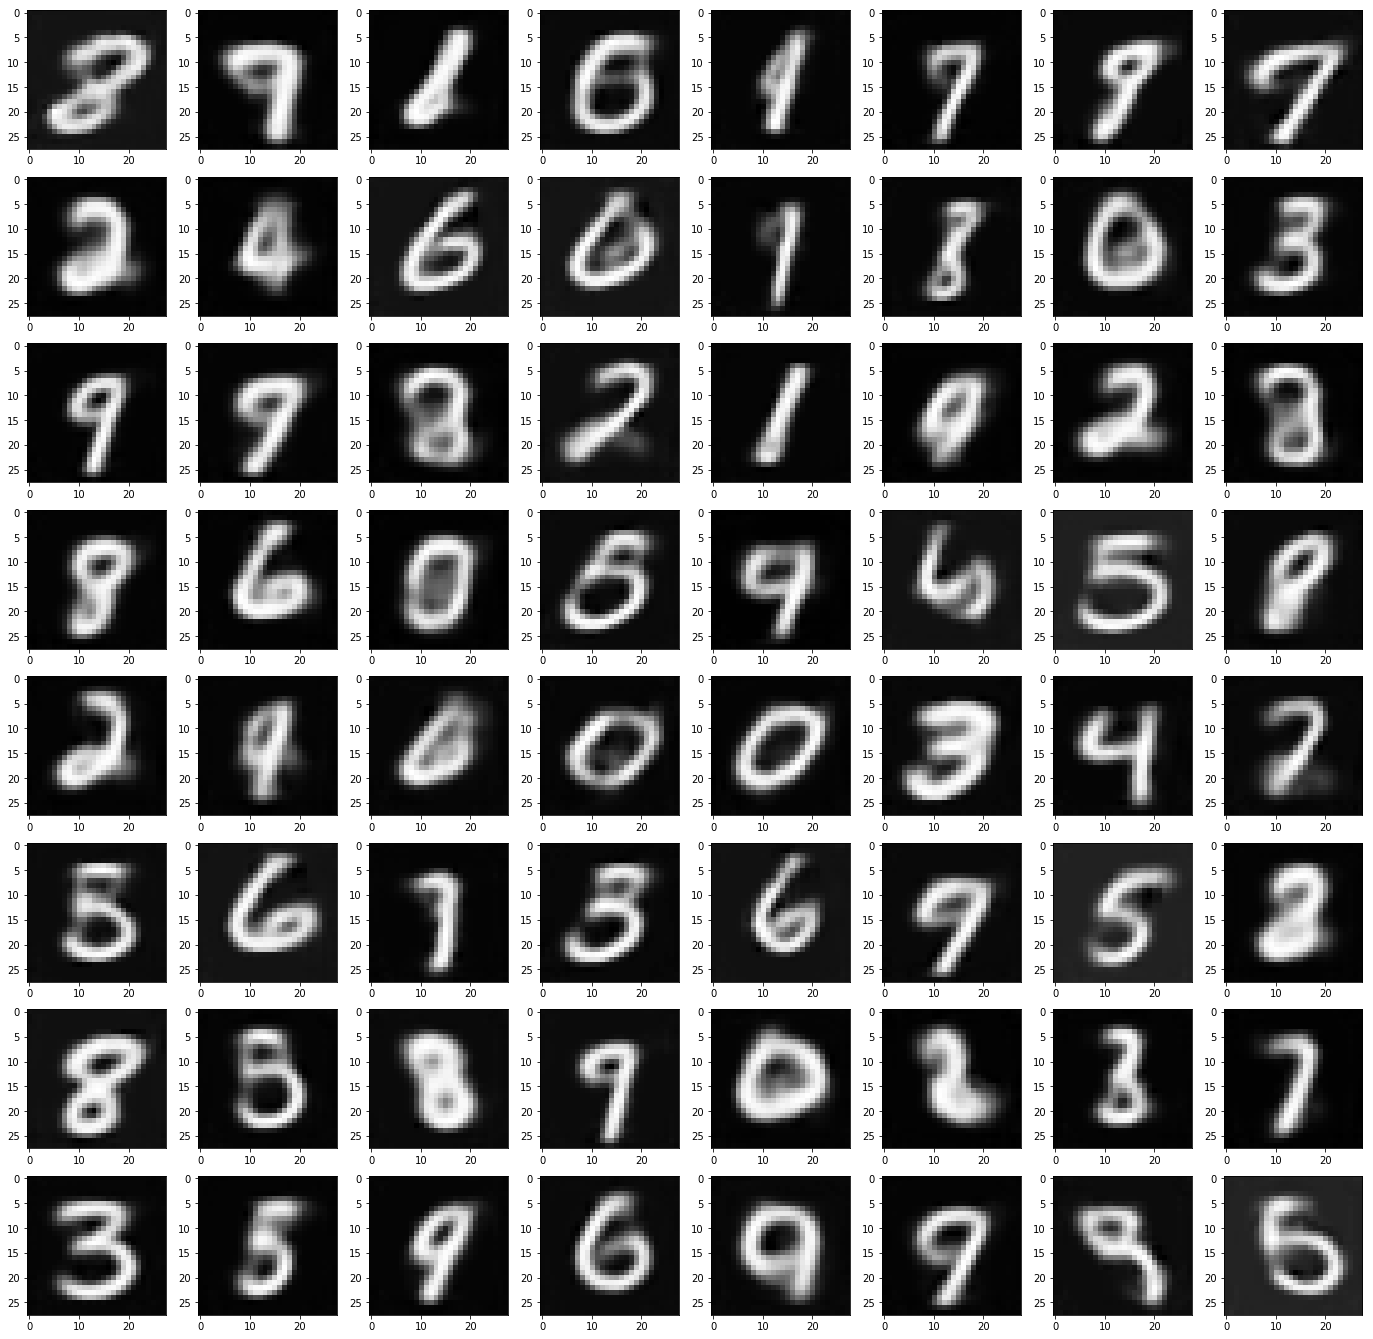

In [23]:
n = 8
imgs = generate(np.random.normal(size=(n * n, 64)).astype('float32'))

plt.subplots(ncols=n, nrows=n, figsize=(n * 3, n * 3))

for i in range(n):
    for j in range(n):
        k = i * n + j
        
        plt.subplot(n, n, k + 1)
        plt.imshow(imgs[k, 0], cmap=plt.cm.Greys_r)
plt.show()

In [34]:
get_loss = theano.function([X], reconstruction_errors + code_errors - code_size / 2)

In [43]:
def get_prob_estimate(x):
    l = np.zeros(shape=x.shape[0])
    for _ in range(1024):
        l += get_loss(x)

    l /= 1024
    return np.exp(-l)

In [44]:
n = 8

probs = get_prob_estimate(X_test[:(n * n)])

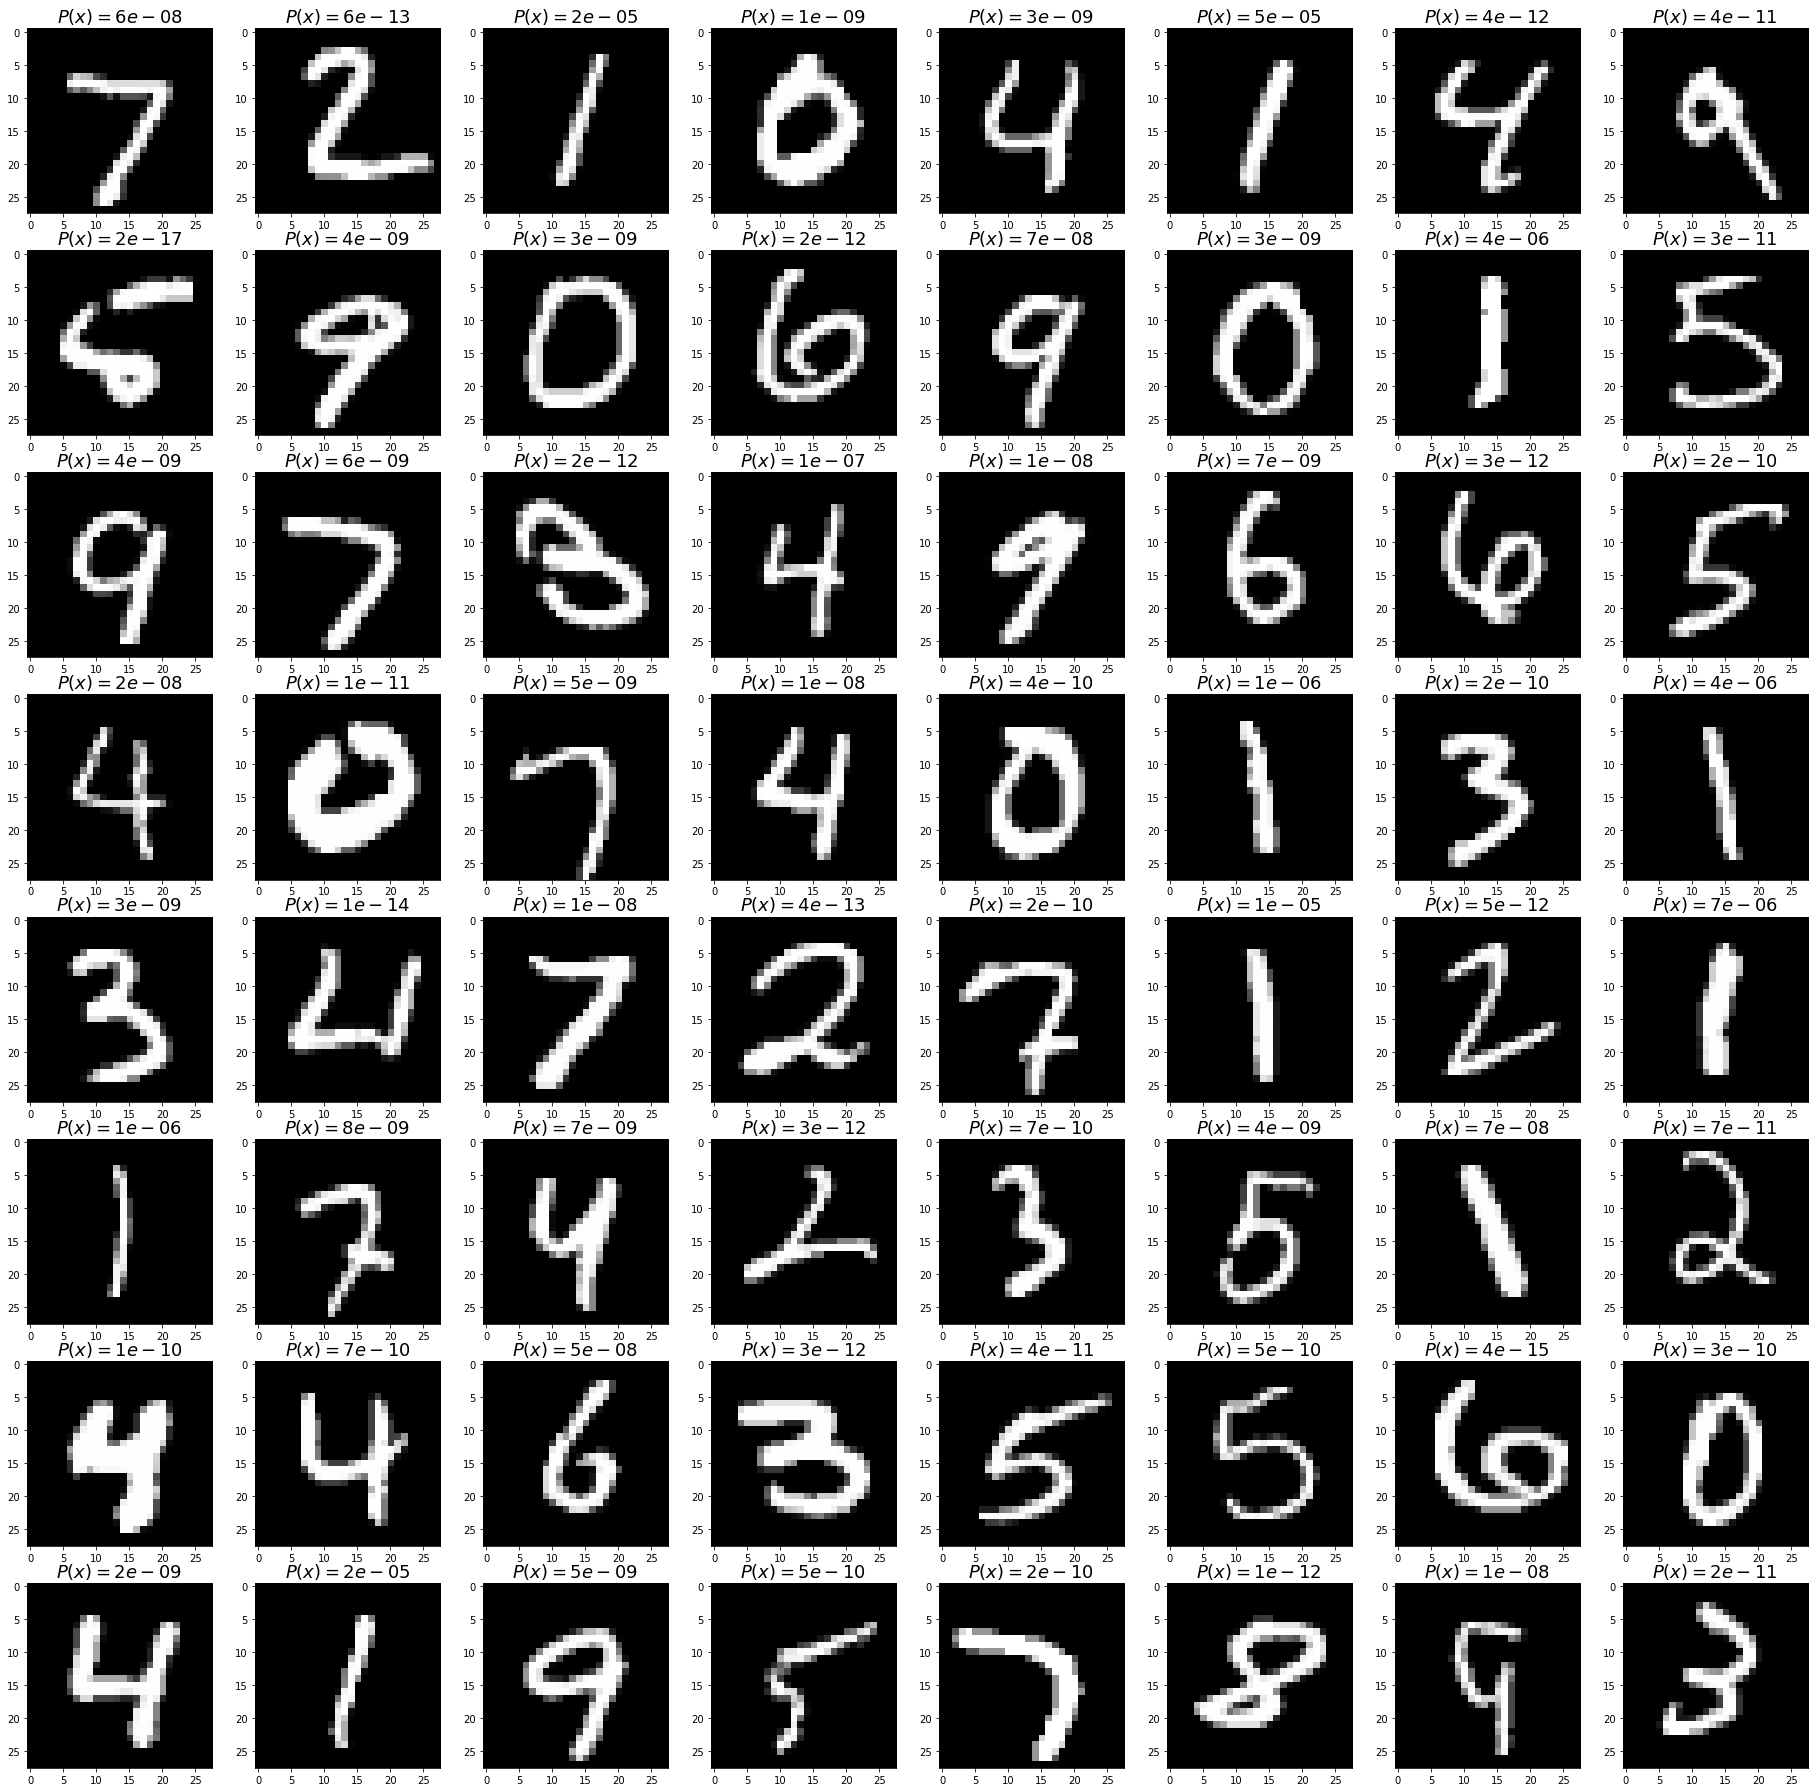

In [48]:
plt.subplots(ncols=n, nrows=n, figsize=(n * 4, n * 4))

for i in range(n):
    for j in range(n):
        k = i * n + j
        
        plt.subplot(n, n, k + 1)
        plt.title(r'$P(x) = %2.e$' % probs[k], fontsize=18)
        plt.imshow(X_test[k, 0], cmap=plt.cm.Greys_r)
plt.show()